In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Background

In [21]:
from scripts.kernel_solvers import predict, solve_l2_problem

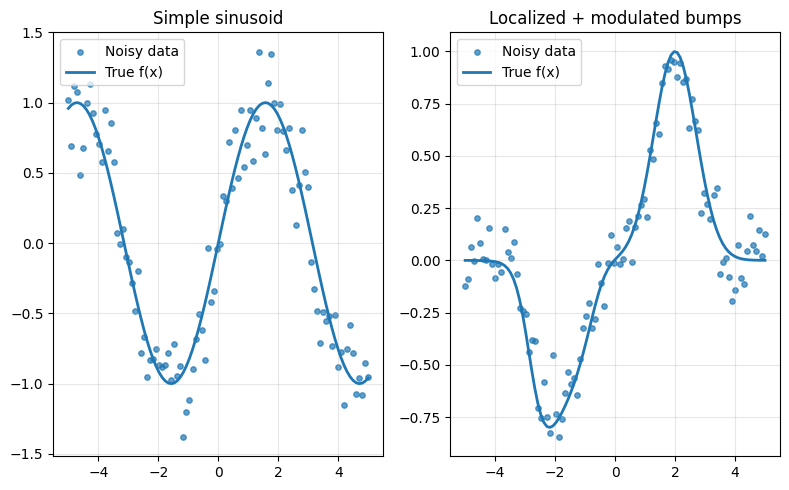

In [22]:
# Toy dataset
n = 100

X = np.linspace(-5, 5, n).reshape(-1, 1)
X_test = np.linspace(-6, 6, 100).reshape(-1, 1)

y_sin_star = np.sin(X).ravel()
y_sin = y_sin_star + 0.2 * np.random.randn(n)

y_2_star = (
    np.exp(-(X - 2)**2)                          # bump near +2
    - 0.8 * np.exp(-(X + 2 + 0.2*np.sin(2*X))**2)  # distorted bump near -2
).ravel()

y_2 = y_2_star + 0.1 * np.random.randn(n)

fig, ax = plt.subplots(1, 2, figsize=(8, 5))

ax[0].scatter(X, y_sin, s=15, alpha=0.7, label="Noisy data")
ax[0].plot(X, y_sin_star, lw=2, label="True f(x)")
ax[0].set_title("Simple sinusoid")
ax[0].legend()
ax[0].grid(alpha=0.3)

ax[1].scatter(X, y_2, s=15, alpha=0.7, label="Noisy data")
ax[1].plot(X, y_2_star, lw=2, label="True f(x)")
ax[1].set_title("Localized + modulated bumps")
ax[1].legend()
ax[1].grid(alpha=0.3)

plt.tight_layout()


In [23]:
alpha = solve_l2_problem(X,y_sin)
alpha_2 = solve_l2_problem(X, y_2,reg=1e-3, sigma=0.7)

y_pred1 = predict(X_test, X, alpha)
y_pred2 = predict(X_test, X, alpha_2)

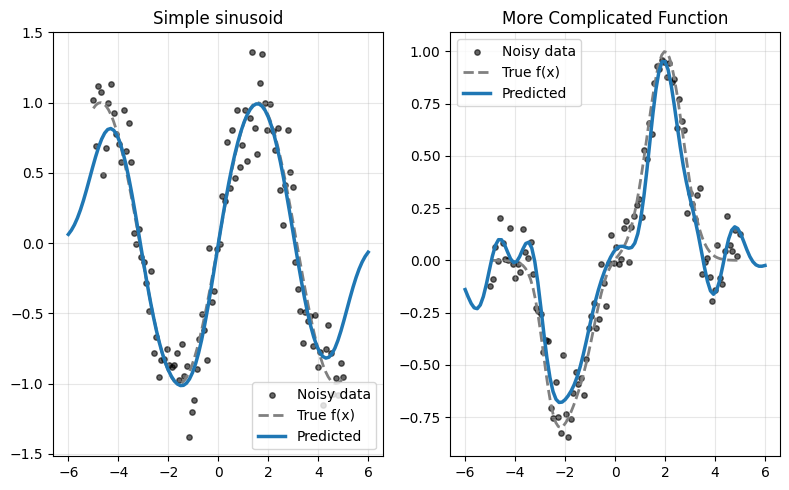

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(8, 5))

ax[0].scatter(X, y_sin, s=15, alpha=0.6, label="Noisy data", marker="o",color="black")
ax[0].plot(X, y_sin_star, label="True f(x)", linestyle="--", color="grey", linewidth=2)
ax[0].plot(X_test,y_pred1,label="Predicted",color = "#1f77b4", linewidth=2.5)
ax[0].set_title("Simple sinusoid")
ax[0].legend()
ax[0].grid(alpha=0.3)

ax[1].scatter(X, y_2, s=15, alpha=0.6, label="Noisy data", marker="o",color="black")
ax[1].plot(X, y_2_star, lw=2, label="True f(x)",linestyle="--", color="grey")
ax[1].plot(X_test,y_pred2,label="Predicted",color = "#1f77b4", linewidth=2.5)
ax[1].set_title("More Complicated Function")
ax[1].legend()
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("KRR_example.png", dpi=250)


## Nystrom Method

In [25]:
from scripts.kernel_solvers import solve_l2_problem_Nystrom

n = 1000

X = np.linspace(-5, 5, n).reshape(-1, 1)
X_test = np.linspace(-6, 6, 100).reshape(-1, 1)

y_sin_star = np.sin(X).ravel()
y_sin = y_sin_star + 0.2 * np.random.randn(n)

y_2_star = (
    np.exp(-(X - 2)**2)                          # bump near +2
    - 0.8 * np.exp(-(X + 2 + 0.2*np.sin(2*X))**2)  # distorted bump near -2
).ravel()

y_2 = y_2_star + 0.1 * np.random.randn(n)


In [26]:
sigma = 1.0
reg   = 1e-2
m     = 50

alpha_sin = solve_l2_problem(X, y_sin, sigma=sigma, reg=reg)
beta_sin, idx_sin = solve_l2_problem_Nystrom(X, y_sin, m=m, sigma=sigma, reg=reg)

y_pred_sin_vanilla = predict(X_test, X, alpha_sin)
y_pred_sin_nys     = predict(X_test, X[idx_sin], beta_sin)

# --- Function 2 : bump function
alpha_2 = solve_l2_problem(X, y_2, sigma=sigma, reg=reg)
beta_2, idx_2 = solve_l2_problem_Nystrom(X, y_2, m=m, sigma=sigma, reg=reg)

y_pred_2_vanilla = predict(X_test, X, alpha_2)
y_pred_2_nys     = predict(X_test, X[idx_2], beta_2)


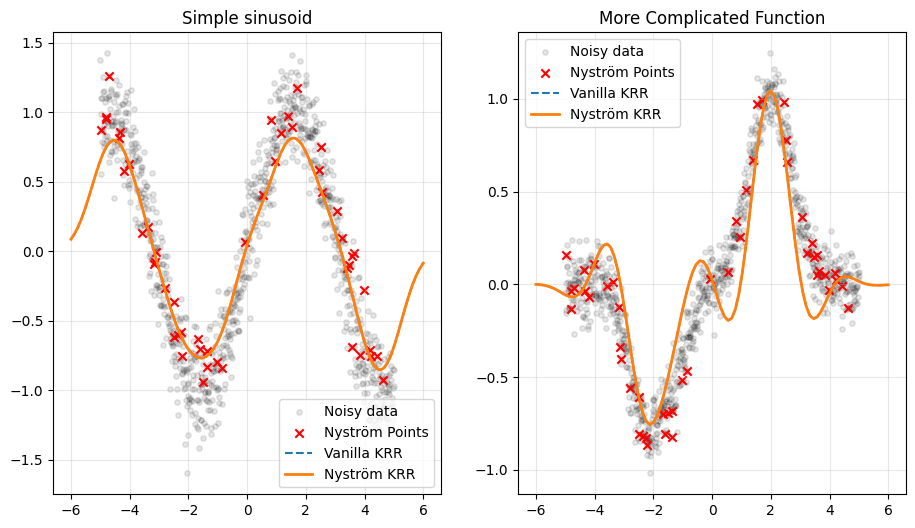

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(11, 6))

# Plot points
ax[0].scatter(X, y_sin, s=15, alpha=0.1, label="Noisy data", marker="o",color="black")
ax[0].scatter(X[idx_sin], y_sin[idx_sin], label="Nyström Points",marker="x",color="red")
ax[0].plot(X_test, y_pred_sin_vanilla, label="Vanilla KRR", linestyle="--")
ax[0].plot(X_test, y_pred_sin_nys, lw=2, label="Nyström KRR")
ax[0].set_title("Simple sinusoid")
ax[0].legend(loc="best")
ax[0].grid(alpha=0.3)

# Plot points
ax[1].scatter(X, y_2, s=15, alpha=0.1, label="Noisy data", marker="o",color="black")
ax[1].scatter(X[idx_sin], y_2[idx_sin], label="Nyström Points",marker="x",color="red")
ax[1].plot(X_test, y_pred_2_vanilla, label="Vanilla KRR", linestyle="--")
ax[1].plot(X_test, y_pred_2_nys, lw=2, label="Nyström KRR")
ax[1].set_title("More Complicated Function")
ax[1].legend(loc="best")
ax[1].grid(alpha=0.3)

plt.savefig("figures/nystrom_toy.png")

NameError: name 'indices' is not defined

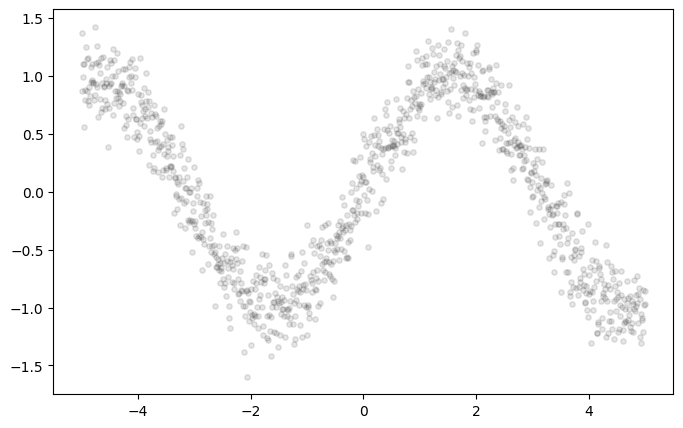

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.scatter(X, y_sin, s=15, alpha=0.1, label="Noisy data", marker="o",color="black",zorder=1)
ax.scatter(X[indices],y_sin[indices], marker="x", color="#d62728",label="Nyström points", zorder=2)
ax.plot(X_test,y_pred_nys,color ="#1f77b4", linewidth=2.5,label="KRR (Nyström) $m=50$")
ax.plot(X_test, y_pred, linestyle="-.", linewidth=2, color="#2ca02c", label="Vanilla KRR", zorder=2.8
)
ax.set_title("Kernel Ridge Regression with Nyström Approximation $m=50$, $n=1000$")
ax.legend()
ax.grid(alpha=0.3)
plt.savefig("Nystrom_toy.png",dpi=250)

## Nystrom Conditioning

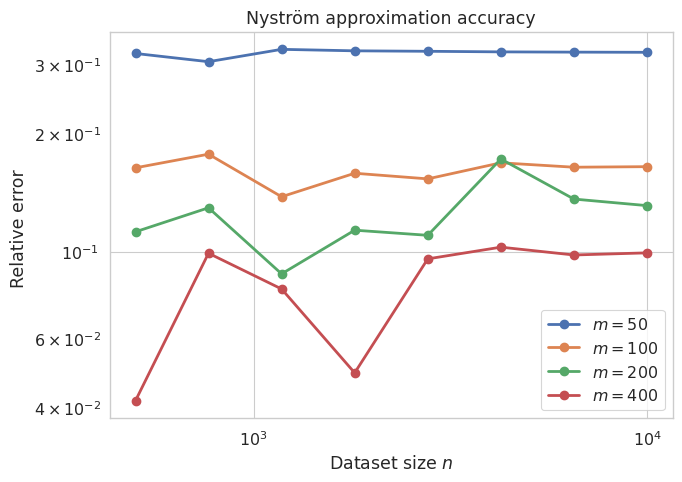

In [ ]:
# ---------------------
# Single experiment
# ---------------------
def nystrom_error(n, m, sigma=1.0, seed=0):
    rng = np.random.default_rng(seed)

    X = np.linspace(-5, 5, n).reshape(-1, 1)
    idx = rng.choice(n, size=m, replace=False)
    Xm = X[idx]

    K_nm = rbf_kernel(X, Xm, sigma)
    K_mm = rbf_kernel(Xm, Xm, sigma)

    A_full   = K_nm.T @ K_nm
    A_approx = (n / m) * (K_mm @ K_mm)

    return (
        np.linalg.norm(A_full - A_approx, ord="fro")
        / np.linalg.norm(A_full, ord="fro")
    )


# ---------------------
# Parameter sweep
# ---------------------
n_values = np.unique(
    np.logspace(2.7, 4.0, 8).astype(int)
)   # ~500 → 10,000   (log-spaced)

m_values = [50, 100, 200, 400]

errors = {m: [] for m in m_values}

for m in m_values:
    for n in n_values:
        err = nystrom_error(n, m, sigma=1.0, seed=0)
        errors[m].append(err)


plt.figure(figsize=(7, 5))

for m in m_values:
    plt.plot(
        n_values,
        errors[m],
        marker="o",
        linewidth=2,
        markersize=6,
        label=rf"$m={m}$"
    )

plt.xscale("log")
plt.yscale("log")

plt.xlabel(r"Dataset size $n$")
plt.ylabel(r"Relative error ")

plt.title(r"Nyström approximation accuracy")

plt.legend()
plt.tight_layout()
plt.show()


In [52]:
K_nm = rbf_kernel(X,Xm)
K_mm = rbf_kernel(Xm,Xm)

KeyboardInterrupt: 